In [3]:
# Setup and Imports
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc,
    f1_score  
)

# --- Configuration ---
DB_PATH = '../../dataset/supervised_dataset.duckdb'
LABELED_TABLE = 'labeled_training_data_new_approach'
MODEL_PATH = '../../models/supervised/XGBClassifier_model.pkl' 

sns.set_theme(style="whitegrid")

warnings.filterwarnings("ignore")

In [4]:
# Load Labeled Data
print(f"Loading labeled data from '{LABELED_TABLE}'...")
try:
    con = duckdb.connect(database=DB_PATH, read_only=True)
    df = con.query(f"SELECT * FROM {LABELED_TABLE}").to_df()
    con.close()
    
    df['is_insider'] = df['is_insider'].astype(int)
    
    print("Data loaded successfully.")

except Exception as e:
    print(f"--- CRITICAL ERROR: Could not load data ---")
    print(f"Error: {e}")
    raise

Loading labeled data from 'labeled_training_data_new_approach'...
Data loaded successfully.


In [5]:
# Define Features (X) and Target (y)
y = df['is_insider']
X = df.drop(columns=['user_id', 'is_insider'])
feature_names = X.columns.tolist()

In [6]:
# Create Train-Test Split 

print("\nCreating stratified 80/20 train-test split...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42, # Ensures same split as before
    stratify=y
)
print("Test set created successfully.")


Creating stratified 80/20 train-test split...
Test set created successfully.


In [7]:
# Load Model and Get Probabilities
print(f"\nLoading baseline model from '{MODEL_PATH}'...")
try:
    with open(MODEL_PATH, 'rb') as f:
        model = pickle.load(f)
    print("Model loaded successfully.")
except Exception as e:
    print(f"--- CRITICAL ERROR: Could not load model ---")
    print(f"Error: {e}")
    raise

print("Getting model predictions (probabilities)...")
# Get the raw probability scores for the "Insider" class
y_pred_proba = model.predict_proba(X_test)[:, 1]


Loading baseline model from '../../models/supervised/XGBClassifier_model.pkl'...
Model loaded successfully.
Getting model predictions (probabilities)...


In [8]:
# Find Best Threshold (by F1-Score)
print("\nFinding optimal threshold...")

# Get precision, recall, and thresholds for all possible values
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# IMPORTANT!
# The 'thresholds' array is 1 element shorter than 'precisions'
# and 'recalls'. We must slice them to match.
# We also avoid divide-by-zero warnings.

# Calculate F1-Score for all thresholds
with np.errstate(divide='ignore', invalid='ignore'):
    f1_scores = (2 * precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
    f1_scores = np.nan_to_num(f1_scores) # Handle 0/0 cases

# Find the threshold that gave the highest F1-Score
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_threshold = thresholds[best_f1_idx]
best_precision = precisions[best_f1_idx]
best_recall = recalls[best_f1_idx]

print("\n--- Optimal Threshold Found ---")
print(f"  Best F1-Score:    {best_f1:.4f}")
print(f"  Optimal Threshold:  {best_threshold:.4f}")
print(f"  (At this threshold):")
print(f"  > New Recall:     {best_recall:.4f}")
print(f"  > New Precision:  {best_precision:.4f}")



Finding optimal threshold...

--- Optimal Threshold Found ---
  Best F1-Score:    0.8000
  Optimal Threshold:  0.3207
  (At this threshold):
  > New Recall:     0.8571
  > New Precision:  0.7500


In [9]:
# 7. Evaluate with NEW Threshold
print("\n--- New Classification Report (at optimal threshold) ---")

# Apply the new threshold
y_pred_tuned = (y_pred_proba >= best_threshold).astype(int)

print(classification_report(y_test, y_pred_tuned, target_names=["Benign (0)", "Insider (1)"]))


--- New Classification Report (at optimal threshold) ---
              precision    recall  f1-score   support

  Benign (0)       0.99      0.98      0.98       186
 Insider (1)       0.75      0.86      0.80        14

    accuracy                           0.97       200
   macro avg       0.87      0.92      0.89       200
weighted avg       0.97      0.97      0.97       200




--- P-R Curve with Optimal Point ---


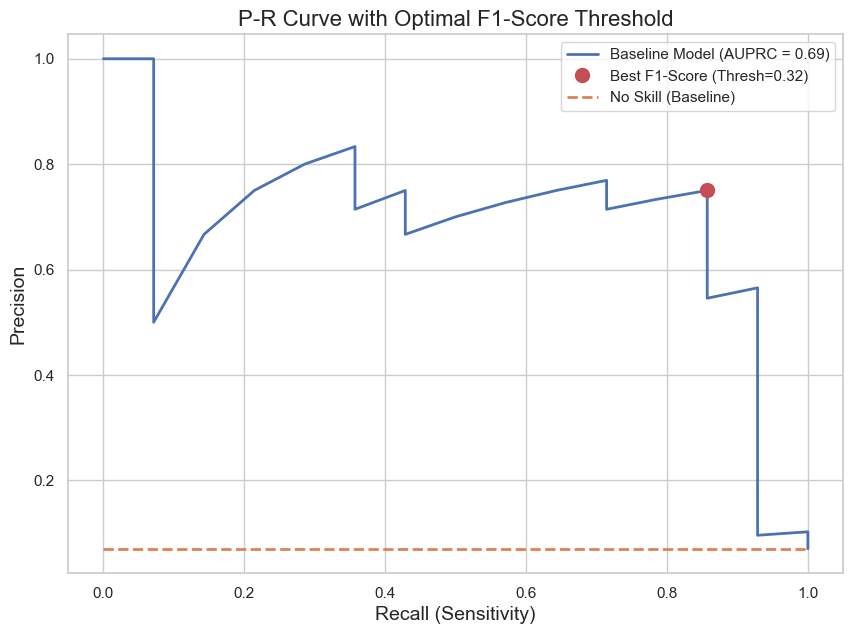

In [10]:
# 8. Visualize the Optimal Point
print("\n--- P-R Curve with Optimal Point ---")

pr_auc = auc(recalls, precisions)

plt.figure(figsize=(10, 7))
plt.plot(recalls, precisions, lw=2, label=f'Baseline Model (AUPRC = {pr_auc:.2f})')

# Plot the "sweet spot" we found
plt.plot(
    best_recall, 
    best_precision, 
    'ro', # Red dot
    markersize=10, 
    label=f'Best F1-Score (Thresh={best_threshold:.2f})'
)

no_skill = (y_test == 1).sum() / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', lw=2, label='No Skill (Baseline)')

plt.xlabel('Recall (Sensitivity)', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('P-R Curve with Optimal F1-Score Threshold', fontsize=16)
plt.legend(loc='best')
plt.show()